In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from google.colab import files
uploaded = files.upload()

Saving 2025 Allianz Datathon Dataset.xlsx to 2025 Allianz Datathon Dataset.xlsx


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load sheets (if not already loaded)
climate = pd.read_excel("2025 Allianz Datathon Dataset.xlsx", sheet_name="Climate Data")

# Clean column names & build date
climate = climate.rename(columns={
    "Bureau of Meteorology station number": "station_id",
    "Maximum temperature (Degree C)": "tmax_c",
    "Minimum temperature (Degree C)": "tmin_c",
    "Rainfall amount (millimetres)": "rain_mm",
})
climate["date"] = pd.to_datetime(dict(year=climate["Year"], month=climate["Month"], day=climate["Day"]))
climate = climate.sort_values(["station_id","date"])

# Station → resort mapping (from your readme)
STATION_TO_RESORT = {
    71032: "Thredbo AWS",
    71075: "Perisher AWS",
    72161: "Cabramurra (Snowy Mts)",
    83024: "Mount Buller",
    83084: "Falls Creek",
    83085: "Mount Hotham",
    85291: "Mount Baw Baw",
}
climate["resort"] = climate["station_id"].map(STATION_TO_RESORT)


In [ ]:
from datetime import datetime, timedelta

WEEK_STARTS = ["06-09","06-16","06-23","06-30","07-07","07-14","07-21","07-28",
               "08-04","08-11","08-18","08-25","09-01","09-08","09-15"]  # MM-DD

def add_ski_week_cols(df):
    d = df.copy()
    d["year"] = d["date"].dt.year
    d["month_day"] = d["date"].dt.strftime("%m-%d")

    # flag dates that fall within season (>= 09 Jun and <= 15 Sep of that year)
    def in_season(md):
        return ("06-09" <= md <= "09-15")
    d["in_ski_season"] = d["month_day"].apply(in_season)

    # compute week number 1..15, else 0
    # map each date to the latest week start <= date for that year
    week_starts_by_year = {
        y: [pd.Timestamp(f"{y}-{md}") for md in WEEK_STARTS] for y in d["year"].unique()
    }
    def week_num(row):
        if not row["in_ski_season"]:
            return 0
        starts = week_starts_by_year[row["year"]]
        # last start <= date
        idx = max([i for i,s in enumerate(starts, start=1) if s <= row["date"]], default=0)
        return idx
    d["ski_week"] = d.apply(week_num, axis=1)
    return d

climate = add_ski_week_cols(climate)


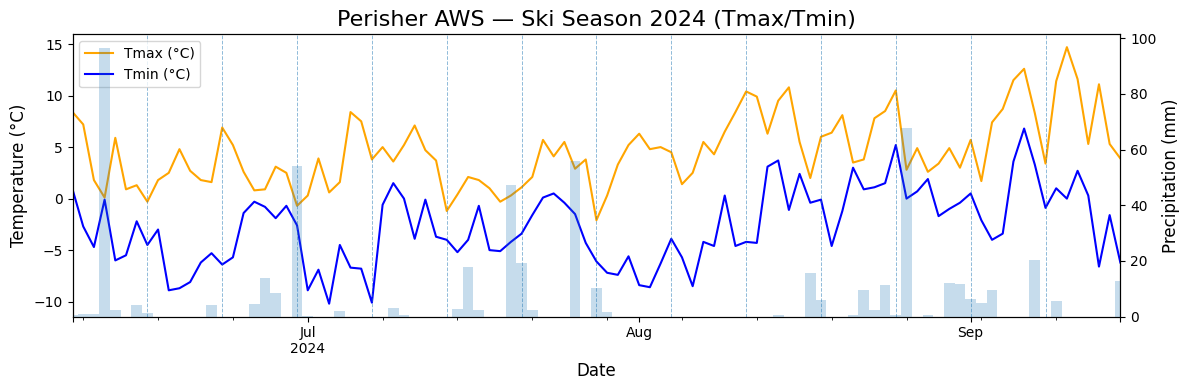

In [ ]:
def plot_resort_year(resort_name, year):
    sub = climate[(climate["resort"] == resort_name) &
                  (climate["date"].dt.year == year) &
                  (climate["in_ski_season"])]

    if sub.empty:
        print(f"No data for {resort_name} in {year}")
        return

    fig, ax1 = plt.subplots(figsize=(12,4))
    sub.plot(x="date", y="tmax_c", ax=ax1, color="orange", label="Tmax (°C)")
    sub.plot(x="date", y="tmin_c", ax=ax1, color="blue",   label="Tmin (°C)")

    ax1.set_title(f"{resort_name} — Ski Season {year} (Tmax/Tmin)")
    ax1.set_xlabel("Date"); ax1.set_ylabel("Temperature (°C)")

    # Secondary axis: precipitation as bars (proxy for snow)
    ax2 = ax1.twinx()
    ax2.bar(sub["date"], sub["rain_mm"].fillna(0), alpha=0.25, width=1.0)
    ax2.set_ylabel("Precipitation (mm)")

    # Vertical lines at week starts for context
    for md in WEEK_STARTS:
        xline = pd.Timestamp(f"{year}-{md}")
        ax1.axvline(xline, ls="--", lw=0.7, alpha=0.5)

    ax1.legend(loc="upper left")
    plt.tight_layout(); plt.show()

# Example:
plot_resort_year("Perisher AWS", 2024)


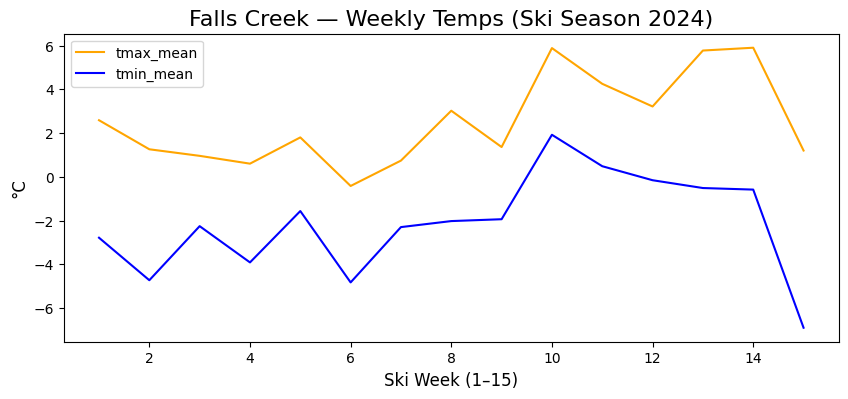

In [ ]:
weekly = (climate[climate["in_ski_season"]]
          .groupby(["resort","year","ski_week"])
          .agg(
              tmax_mean=("tmax_c","mean"),
              tmin_mean=("tmin_c","mean"),
              snow_mm=("rain_mm","sum"),  # precipitation as snow proxy
              days_ok=("tmax_c", lambda s: s.notna().sum())
          )
          .reset_index())

# plot a quick weekly overview for a resort+year
def plot_weekly_overview(resort_name, year):
    w = weekly[(weekly["resort"]==resort_name) & (weekly["year"]==year)]
    if w.empty:
        print("No weekly data"); return
    ax = w.plot(x="ski_week", y=["tmax_mean","tmin_mean"], kind="line",
                figsize=(10,4), color=["orange","blue"])
    ax.set_title(f"{resort_name} — Weekly Temps (Ski Season {year})")
    ax.set_xlabel("Ski Week (1–15)"); ax.set_ylabel("°C")
    plt.show()

# Example:
plot_weekly_overview("Falls Creek", 2024)


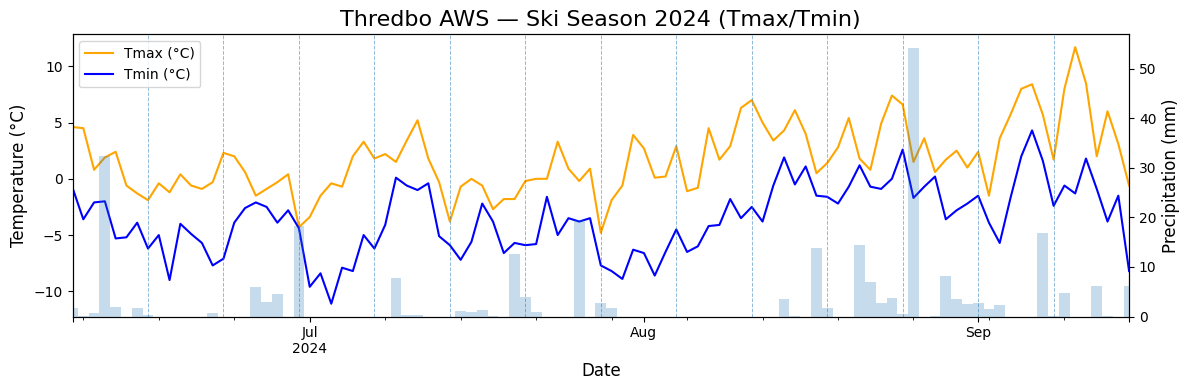

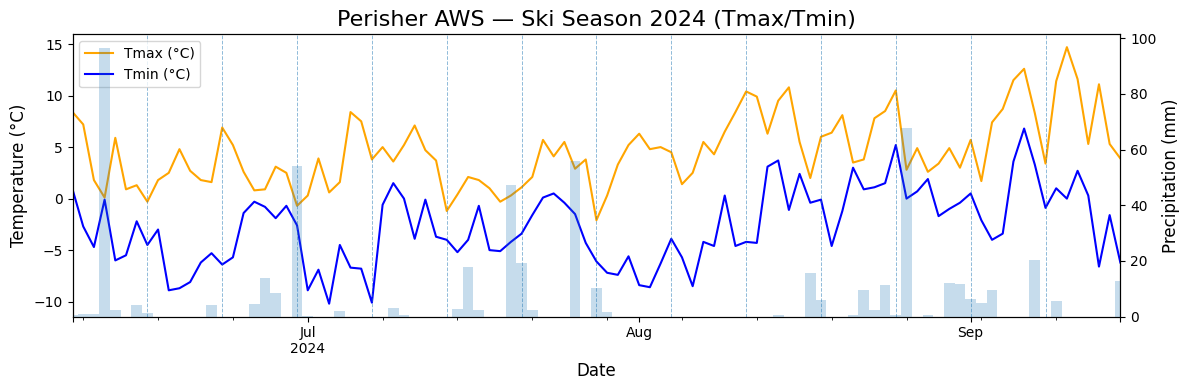

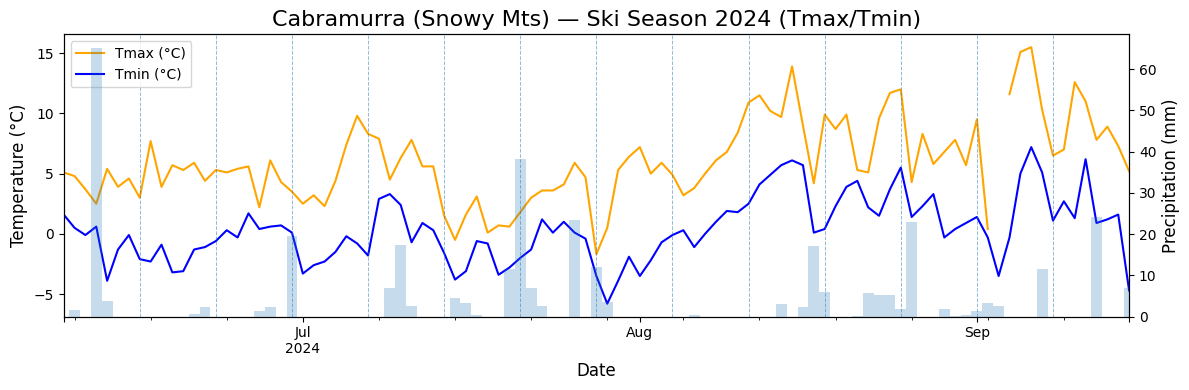

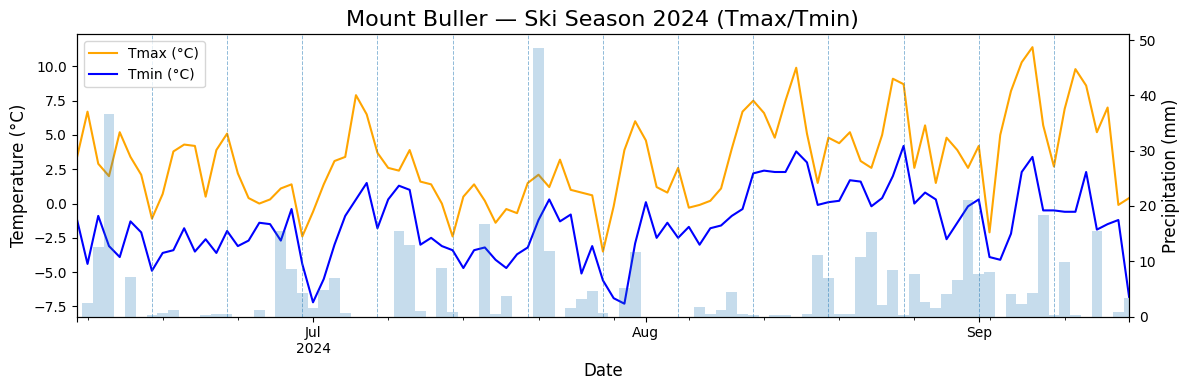

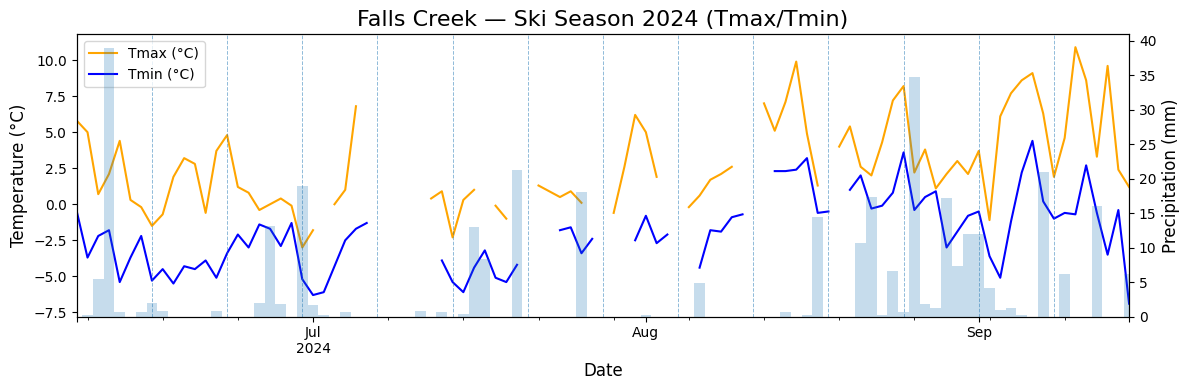

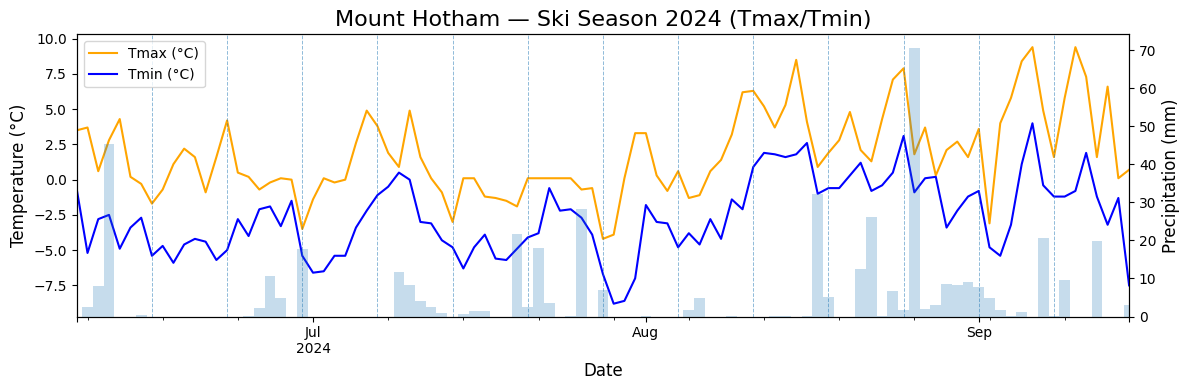

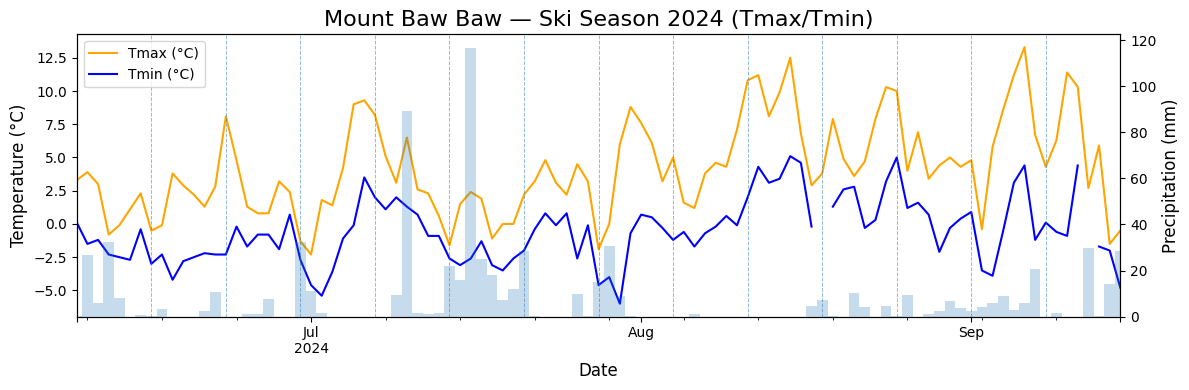

In [ ]:
for r in climate["resort"].dropna().unique():
    plot_resort_year(r, 2024)  # change year as needed


In [ ]:
# --- Plot function (works for all resorts including proxies) ---
def plot_resort_year(resort_name, year):
    sub = climate[(climate["resort"] == resort_name) &
                  (climate["date"].dt.year == year) &
                  (climate["in_ski_season"])].sort_values("date")

    if sub.empty:
        print(f"No data for {resort_name} in {year}")
        return

    plt.figure(figsize=(12,4))
    plt.plot(sub["date"], sub["tmax_c"], color="orange", label="Tmax (°C)")
    plt.plot(sub["date"], sub["tmin_c"], color="blue",   label="Tmin (°C)")

    # Add ski week boundaries
    for md in WEEK_STARTS:
        xline = pd.Timestamp(f"{year}-{md}")
        plt.axvline(xline, ls="--", lw=0.7, alpha=0.5)

    plt.title(f"{resort_name} — Ski Season {year} (Tmax/Tmin)")
    plt.xlabel("Date"); plt.ylabel("Temperature (°C)")
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()



In [ ]:
# If you’ve already done this earlier, you can skip this cell.

WEEK_STARTS = ["06-09","06-16","06-23","06-30","07-07","07-14","07-21","07-28",
               "08-04","08-11","08-18","08-25","09-01","09-08","09-15"]

def add_ski_week_cols(df):
    d = df.copy()
    d["date"] = pd.to_datetime(d["date"])
    d["year"] = d["date"].dt.year
    d["month_day"] = d["date"].dt.strftime("%m-%d")
    d["in_ski_season"] = d["month_day"].between("06-09", "09-15")
    week_starts_by_year = {y: [pd.Timestamp(f"{y}-{md}") for md in WEEK_STARTS]
                           for y in d["year"].unique()}
    def week_num(row):
        if not row["in_ski_season"]:
            return 0
        starts = week_starts_by_year[row["year"]]
        idx = max([i for i,s in enumerate(starts, start=1) if s <= row["date"]], default=0)
        return idx
    d["ski_week"] = d.apply(week_num, axis=1)
    return d

# Stations
THREDBO, PERISHER, BULLER = 71032, 71075, 83024

# Charlotte Pass (proxy: mean of Thredbo + Perisher)
pair = climate[climate["station_id"].isin([THREDBO, PERISHER])].copy()
cp_daily = (pair.groupby("date")
                 .agg(tmax_c=("tmax_c","mean"),
                      tmin_c=("tmin_c","mean"),
                      rain_mm=("rain_mm","mean"))
                 .reset_index())
cp_daily["station_id"] = 99991
cp_daily["resort"]     = "Charlotte Pass (proxy: Thredbo+Perisher)"
cp_daily["Year"] = cp_daily["date"].dt.year; cp_daily["Month"] = cp_daily["date"].dt.month; cp_daily["Day"] = cp_daily["date"].dt.day
cp_daily = add_ski_week_cols(cp_daily)

# Mount Stirling (proxy: Buller)
ms_daily = climate[climate["station_id"]==BULLER][["date","tmax_c","tmin_c","rain_mm"]].copy()
ms_daily["station_id"] = 99992
ms_daily["resort"]     = "Mount Stirling (proxy: Buller)"
ms_daily["Year"] = ms_daily["date"].dt.year; ms_daily["Month"] = ms_daily["date"].dt.month; ms_daily["Day"] = ms_daily["date"].dt.day
ms_daily = add_ski_week_cols(ms_daily)

# Append proxies if not already present
have_cp = (climate.get("resort") == "Charlotte Pass (proxy: Thredbo+Perisher)").any() if "resort" in climate.columns else False
have_ms = (climate.get("resort") == "Mount Stirling (proxy: Buller)").any() if "resort" in climate.columns else False

common_cols = ["station_id","resort","Year","Month","Day","tmax_c","tmin_c","rain_mm","date",
               "year","month_day","in_ski_season","ski_week"]

if not have_cp:
    climate = pd.concat([climate, cp_daily[common_cols]], ignore_index=True)
if not have_ms:
    climate = pd.concat([climate, ms_daily[common_cols]], ignore_index=True)



In [ ]:
# 7 originals + 2 proxies (adjust names if your labels differ)
resorts9 = [
    "Thredbo AWS",
    "Perisher AWS",
    "Cabramurra (Snowy Mts)",
    "Mount Buller",
    "Falls Creek",
    "Mount Hotham",
    "Mount Baw Baw",
    "Charlotte Pass (proxy: Thredbo+Perisher)",
    "Mount Stirling (proxy: Buller)"
]

import matplotlib.pyplot as plt
import pandas as pd

def plot_temps(resort_name, year):
    sub = climate[(climate["resort"] == resort_name) &
                  (climate["date"].dt.year == year) &
                  (climate["in_ski_season"])].sort_values("date")
    if sub.empty:
        print(f"No data for {resort_name} in {year}"); return
    plt.figure(figsize=(12,4))
    plt.plot(sub["date"], sub["tmax_c"], color="orange", label="Tmax (°C)")
    plt.plot(sub["date"], sub["tmin_c"], color="blue",   label="Tmin (°C)")
    for md in WEEK_STARTS:
        plt.axvline(pd.Timestamp(f"{year}-{md}"), ls="--", lw=0.7, alpha=0.5)
    plt.title(f"{resort_name} — Ski Season {year} (Tmax/Tmin)")
    plt.xlabel("Date"); plt.ylabel("Temperature (°C)")
    plt.legend(loc="upper left"); plt.tight_layout(); plt.show()

def plot_rain(resort_name, year):
    sub = climate[(climate["resort"] == resort_name) &
                  (climate["date"].dt.year == year) &
                  (climate["in_ski_season"])].sort_values("date")
    if sub.empty:
        print(f"No data for {resort_name} in {year}"); return
    plt.figure(figsize=(12,3.6))
    plt.plot(sub["date"], sub["rain_mm"].fillna(0))
    for md in WEEK_STARTS:
        plt.axvline(pd.Timestamp(f"{year}-{md}"), ls="--", lw=0.7, alpha=0.5)
    plt.title(f"{resort_name} — Ski Season {year} (Precipitation mm)")
    plt.xlabel("Date"); plt.ylabel("mm")
    plt.tight_layout(); plt.show()


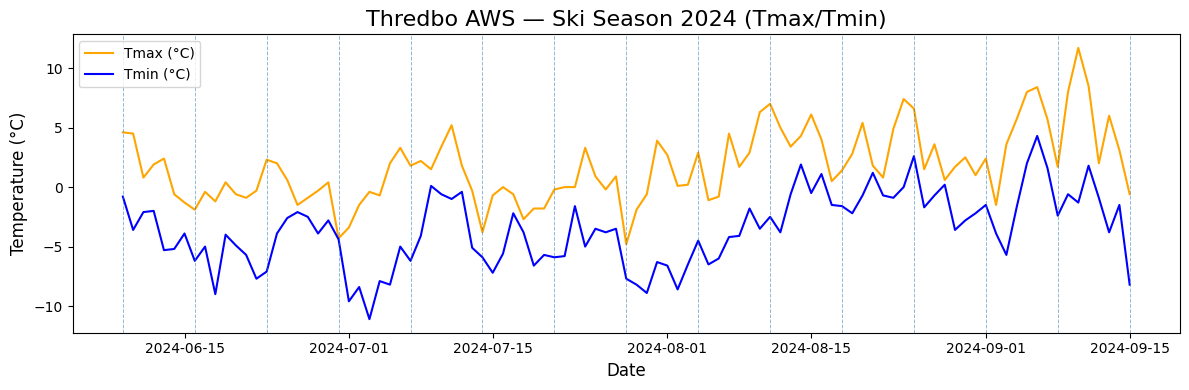

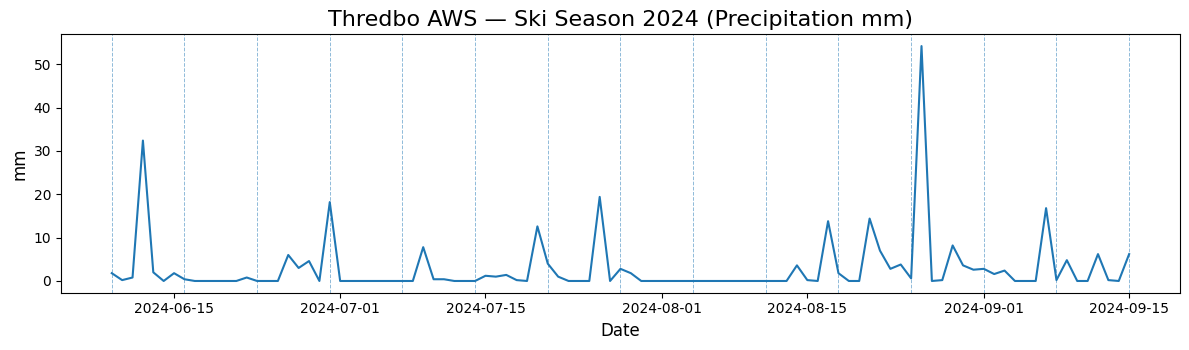

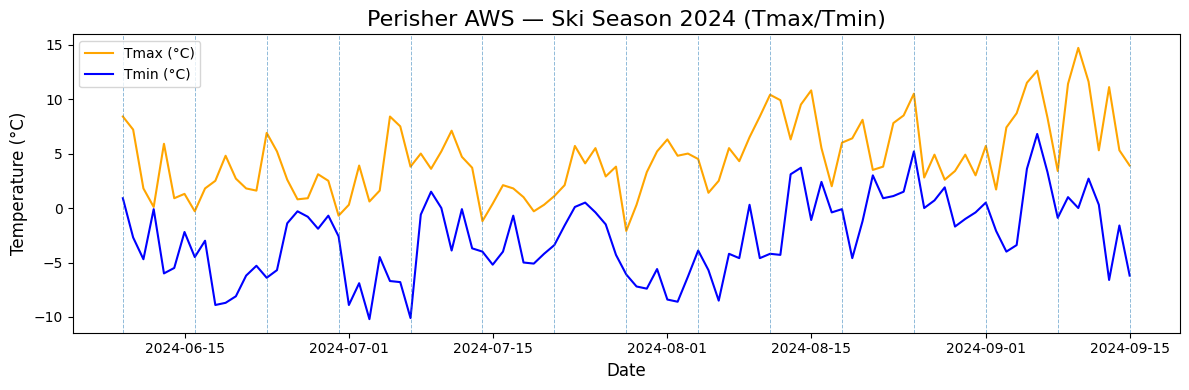

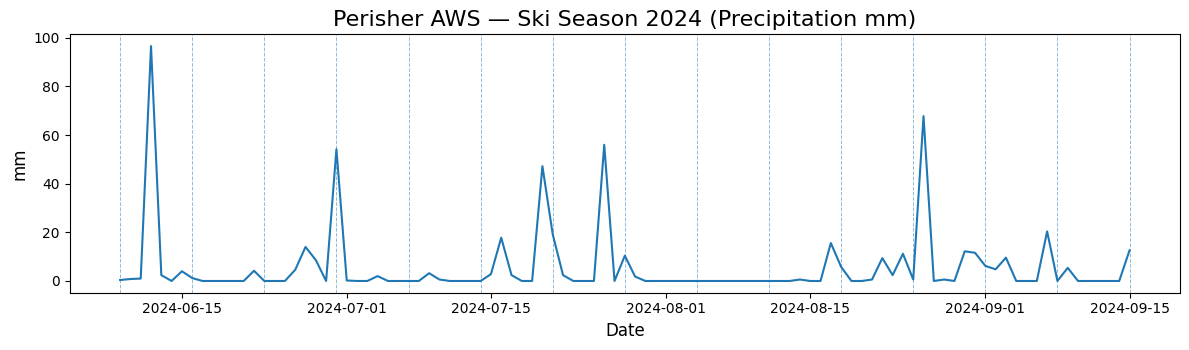

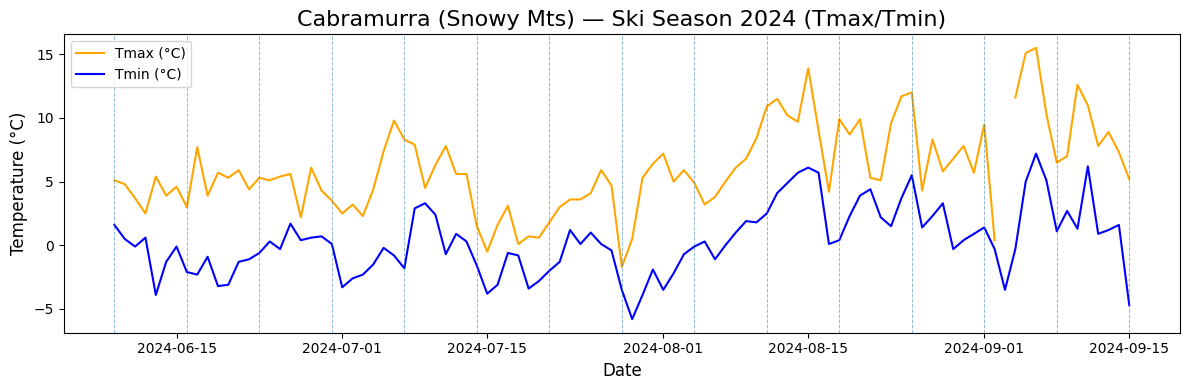

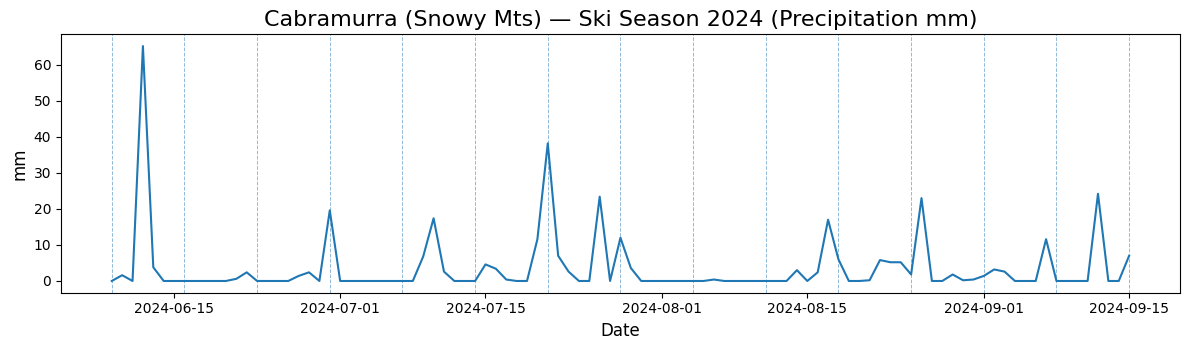

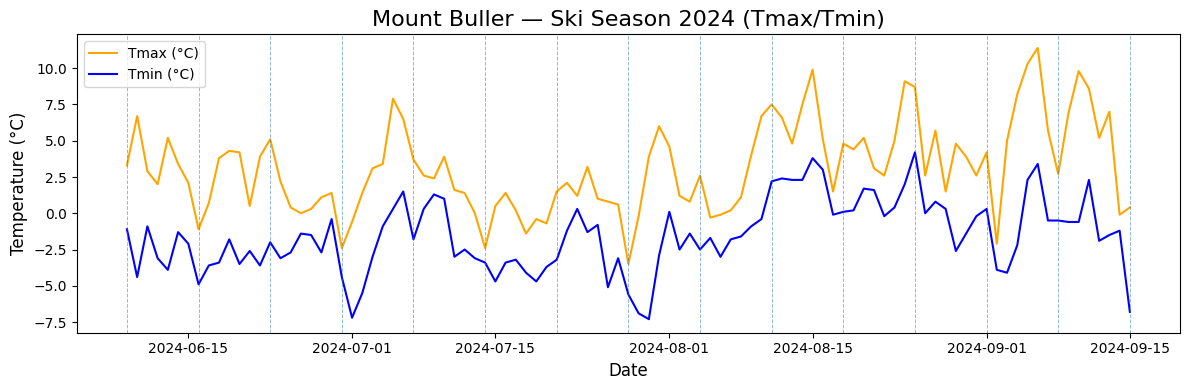

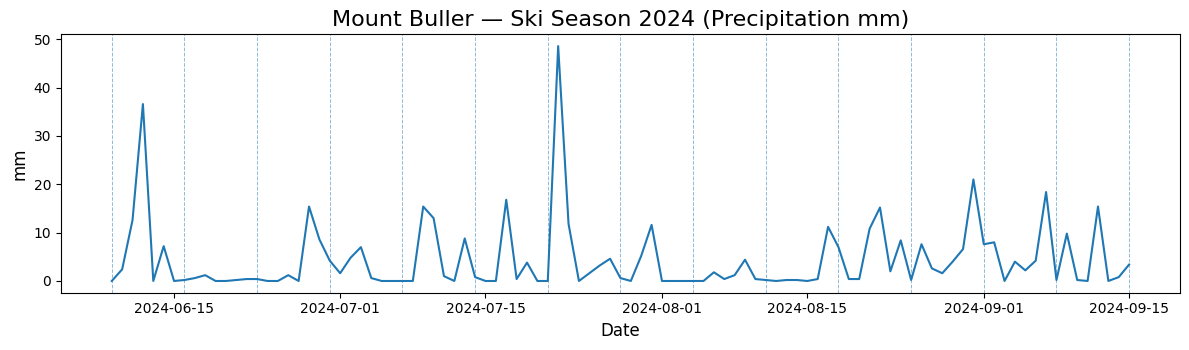

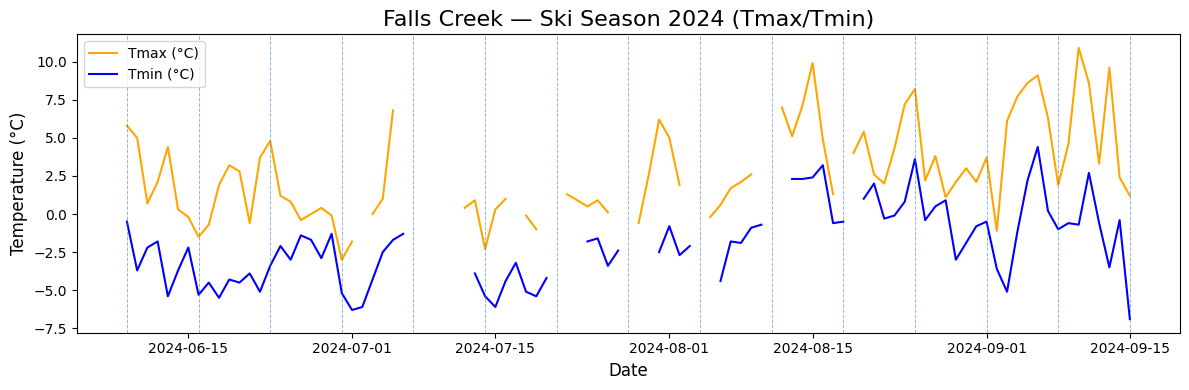

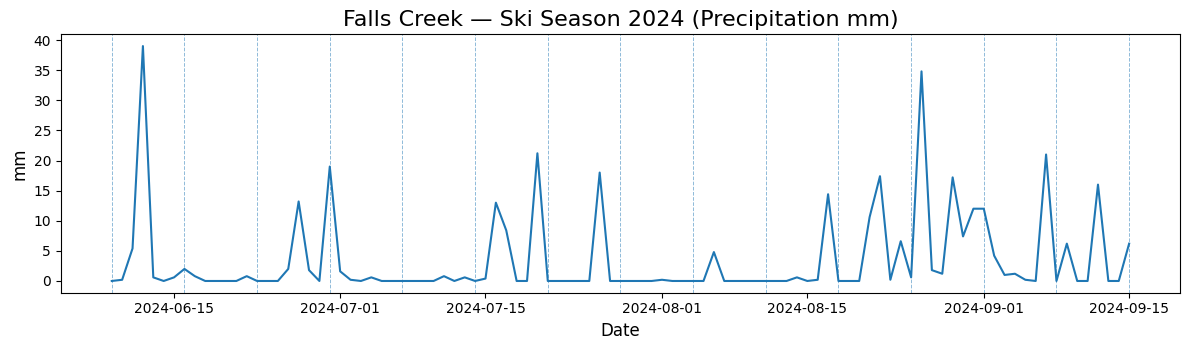

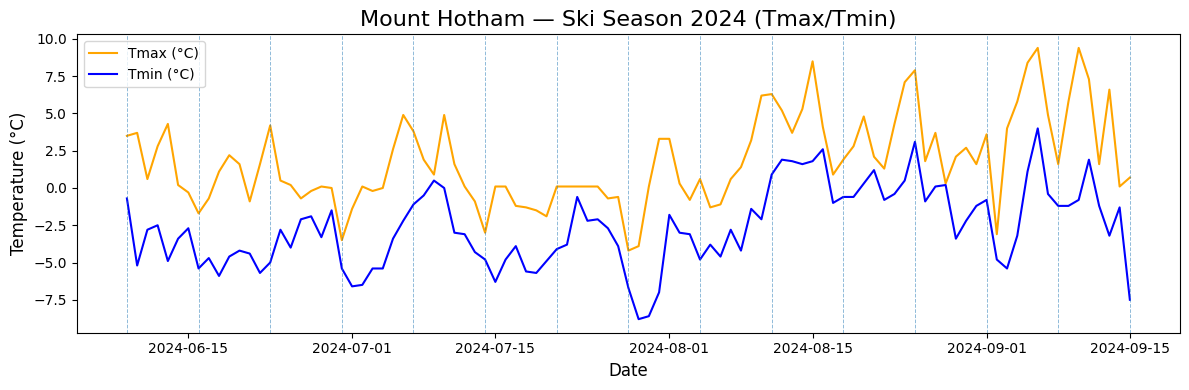

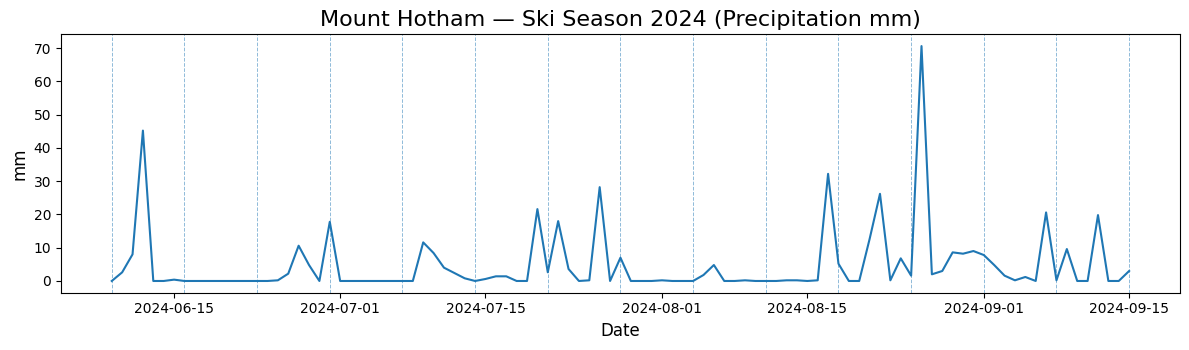

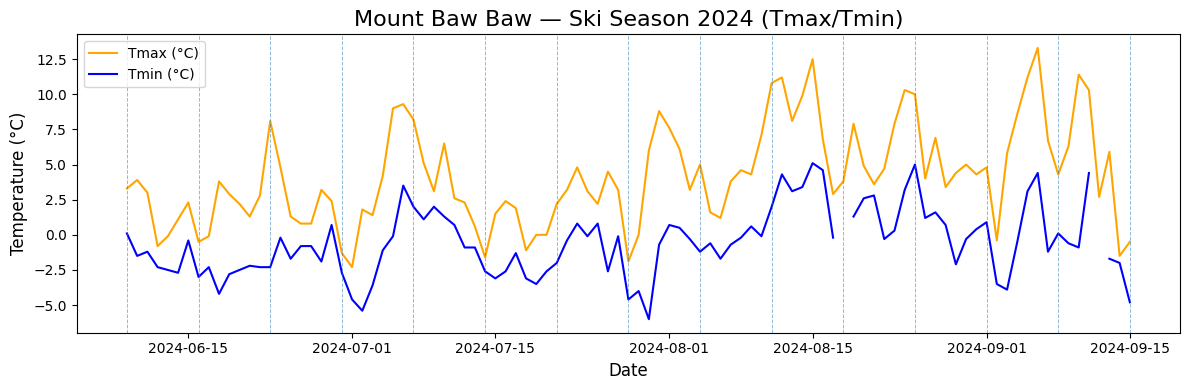

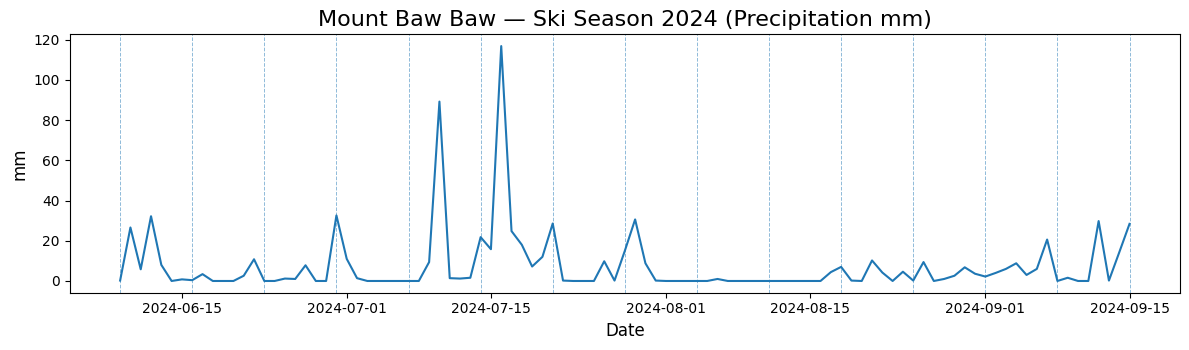

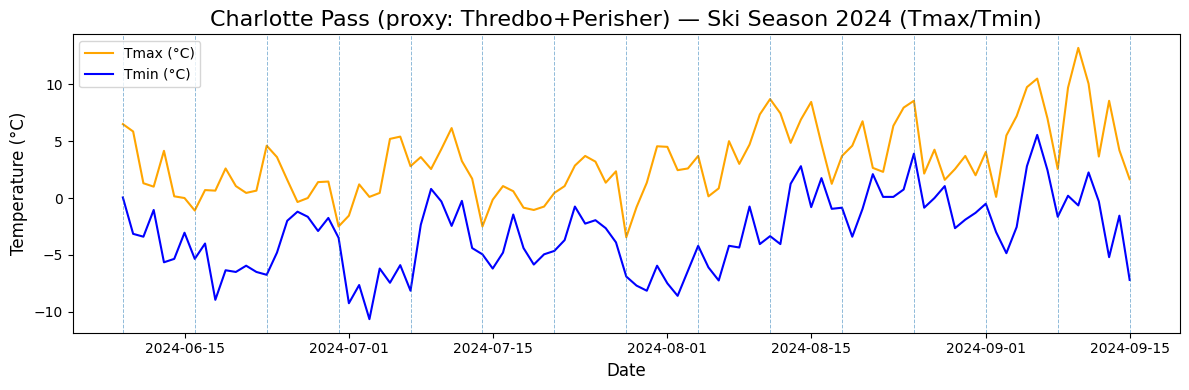

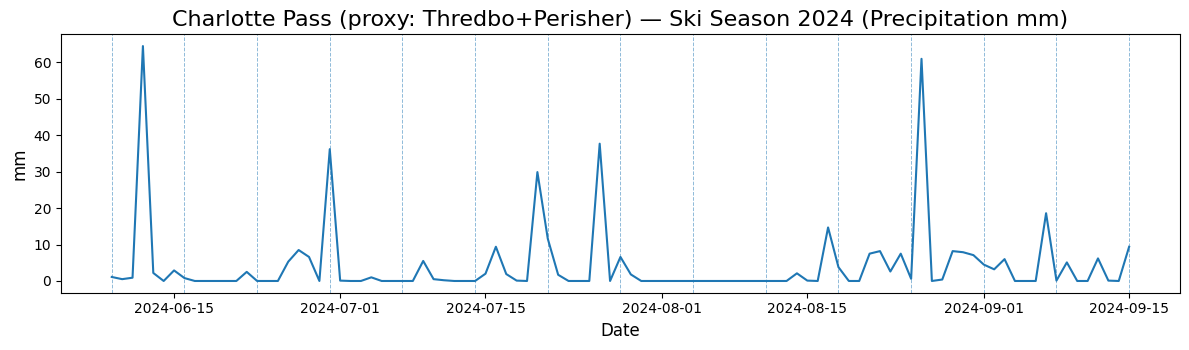

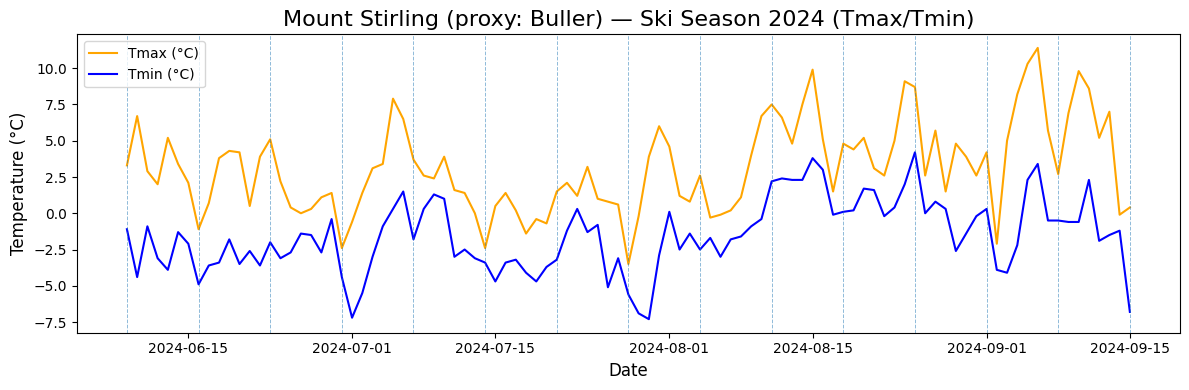

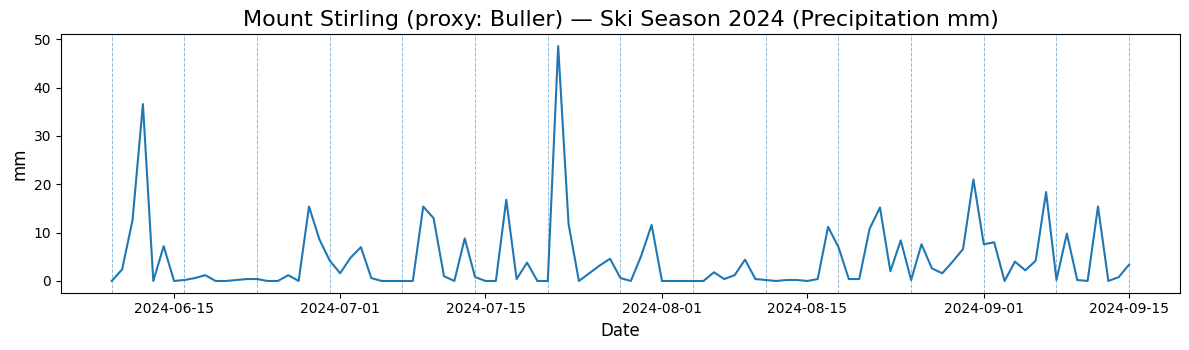

In [ ]:
YEAR = 2024  # change to the year you want

for r in resorts9:
    plot_temps(r, YEAR)
    plot_rain(r, YEAR)


In [ ]:
import matplotlib.pyplot as plt

def plot_weekly_rain(resort_name, year):
    sub = (climate[(climate["resort"] == resort_name) &
                   (climate["date"].dt.year == year) &
                   (climate["in_ski_season"])]
           .groupby("ski_week")["rain_mm"].sum()
           .reset_index())

    if sub.empty:
        print(f"No data for {resort_name} in {year}")
        return

    plt.figure(figsize=(10,4))
    plt.bar(sub["ski_week"], sub["rain_mm"], color="skyblue")

    # Sweet spot zone (20–40 mm/week)
    plt.axhspan(20, 40, color="green", alpha=0.15, label="Optimal zone (20–40 mm)")
    plt.axhline(10, color="orange", linestyle="--", lw=1, label="Low threshold (10mm)")
    plt.axhline(60, color="red", linestyle="--", lw=1, label="High threshold (60mm)")

    plt.title(f"{resort_name} — Weekly Precipitation (Ski Season {year})")
    plt.xlabel("Ski Week (1–15)")
    plt.ylabel("Total Precipitation (mm)")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Example:
plot_weekly_rain("Perisher AWS", 2024)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def plot_weekly_rain_diverging(resort_name, year, low=20, high=40, warn_hi=60):
    # Aggregate to weekly totals
    sub = (climate[(climate["resort"] == resort_name) &
                   (climate["date"].dt.year == year) &
                   (climate["in_ski_season"])]
           .groupby("ski_week")["rain_mm"].sum()
           .reindex(range(1,16))    # ensure weeks 1..15 present
           .fillna(0)
           .reset_index())
    if sub.empty:
        print(f"No data for {resort_name} in {year}");
        return

    weeks = sub["ski_week"].values
    rain  = sub["rain_mm"].values

    # Diverging bars around the optimal midpoint
    midpoint = (low + high) / 2.0  # 30 mm by default
    anomaly  = rain - midpoint     # positive = wetter than mid, negative = drier

    # Color by zone
    colors = []
    for r in rain:
        if r < low:         colors.append("#1f77b4")   # blue: too dry
        elif r <= high:     colors.append("#2ca02c")   # green: optimal
        elif r <= warn_hi:  colors.append("#ff7f0e")   # orange: high
        else:               colors.append("#d62728")   # red: stormy

    plt.figure(figsize=(12,4.5))
    bars = plt.bar(weeks, anomaly, color=colors)

    # Zero line (optimal midpoint)
    plt.axhline(0, color="#666", linewidth=1)

    # Reference bands (optional, light shading for context)
    plt.axhspan(low-midpoint, high-midpoint, color="#2ca02c", alpha=0.10)  # optimal band
    plt.axhline(warn_hi-midpoint, color="#d62728", linestyle="--", linewidth=1)  # storm line
    plt.axhline(low-midpoint,     color="#1f77b4", linestyle="--", linewidth=1)  # dry line
    plt.axhline(high-midpoint,    color="#ff7f0e", linestyle="--", linewidth=1)  # high line

    # Labels & title
    plt.title(f"{resort_name} — Weekly Precipitation Anomaly (vs {midpoint:.0f} mm) • Ski {year}")
    plt.xlabel("Ski Week (1–15)")
    plt.ylabel("Anomaly (mm from optimal midpoint)")

    # X ticks and small grid
    plt.xticks(weeks)
    plt.grid(axis="y", alpha=0.25, linestyle=":")

    # Legend patches
    from matplotlib.patches import Patch
    legend_elems = [
        Patch(color="#1f77b4", label=f"Dry (<{low} mm)"),
        Patch(color="#2ca02c", label=f"Optimal ({low}–{high} mm)"),
        Patch(color="#ff7f0e", label=f"High ({high+1}–{warn_hi} mm)"),
        Patch(color="#d62728", label=f"Stormy (> {warn_hi} mm)")
    ]
    plt.legend(handles=legend_elems, ncol=2, frameon=False)

    plt.tight_layout()
    plt.show()

# Example:
# plot_weekly_rain_diverging("Perisher AWS", 2024)
# plot_weekly_rain_diverging("Charlotte Pass (proxy: Thredbo+Perisher)", 2024)


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ---------- SETTINGS ----------
YEAR = 2025
LOW  = 10    # too low if < 10 mm/week
HIGH = 60    # too high if > 60 mm/week

# ---------- 1) Load / standardize (skip if `climate` already exists) ----------
try:
    climate
except NameError:
    climate = pd.read_excel("2025 Allianz Datathon Dataset.xlsx", sheet_name="Climate Data")
    climate = climate.rename(columns={
        "Bureau of Meteorology station number": "station_id",
        "Maximum temperature (Degree C)": "tmax_c",
        "Minimum temperature (Degree C)": "tmin_c",
        "Rainfall amount (millimetres)": "rain_mm",
    })
    climate["date"] = pd.to_datetime(dict(year=climate["Year"], month=climate["Month"], day=climate["Day"]))

# Map station → resort if not already present
if "resort" not in climate.columns:
    STATION_TO_RESORT = {
        71032: "Thredbo AWS",
        71075: "Perisher AWS",
        72161: "Cabramurra (Snowy Mts)",
        83024: "Mount Buller",
        83084: "Falls Creek",
        83085: "Mount Hotham",
        85291: "Mount Baw Baw",
    }
    climate["resort"] = climate["station_id"].map(STATION_TO_RESORT)

# ---------- 2) Add ski-week columns ----------
WEEK_STARTS = ["06-09","06-16","06-23","06-30","07-07","07-14","07-21","07-28",
               "08-04","08-11","08-18","08-25","09-01","09-08","09-15"]

def add_ski_week_cols(df):
    d = df.copy()
    d["date"] = pd.to_datetime(d["date"])
    d["year"] = d["date"].dt.year
    d["month_day"] = d["date"].dt.strftime("%m-%d")
    d["in_ski_season"] = d["month_day"].between("06-09", "09-15")
    week_starts_by_year = {y: [pd.Timestamp(f"{y}-{md}") for md in WEEK_STARTS] for y in d["year"].unique()}
    def week_num(row):
        if not row["in_ski_season"]:
            return 0
        starts = week_starts_by_year[row["year"]]
        return max([i for i,s in enumerate(starts, start=1) if s <= row["date"]], default=0)
    d["ski_week"] = d.apply(week_num, axis=1)
    return d

climate = add_ski_week_cols(climate)

# ---------- 3) Add proxies (Charlotte Pass, Mount Stirling) if missing ----------
def ensure_proxies(df):
    have_cp = "Charlotte Pass (proxy: Thredbo+Perisher)" in set(df["resort"].dropna().unique())
    have_ms = "Mount Stirling (proxy: Buller)" in set(df["resort"].dropna().unique())

    out = df
    if not have_cp:
        pair = df[df["station_id"].isin([71032, 71075])]
        if not pair.empty:
            cp = (pair.groupby("date").agg(tmax_c=("tmax_c","mean"),
                                           tmin_c=("tmin_c","mean"),
                                           rain_mm=("rain_mm","mean")).reset_index())
            cp["station_id"] = 99991
            cp["resort"] = "Charlotte Pass (proxy: Thredbo+Perisher)"
            cp["Year"] = cp["date"].dt.year; cp["Month"] = cp["date"].dt.month; cp["Day"] = cp["date"].dt.day
            cp = add_ski_week_cols(cp)
            out = pd.concat([out, cp[out.columns]], ignore_index=True)

    if not have_ms:
        buller = df[df["station_id"] == 83024][["date","tmax_c","tmin_c","rain_mm"]].copy()
        if not buller.empty:
            buller["station_id"] = 99992
            buller["resort"] = "Mount Stirling (proxy: Buller)"
            buller["Year"] = buller["date"].dt.year; buller["Month"] = buller["date"].dt.month; buller["Day"] = buller["date"].dt.day
            buller = add_ski_week_cols(buller)
            out = pd.concat([out, buller[out.columns]], ignore_index=True)
    return out

climate = ensure_proxies(climate)

# ---------- 4) Simple precip plot (bars with only too-low / too-high highlight) ----------
def plot_weekly_rain_simple(resort_name, year, low=LOW, high=HIGH):
    sub = (climate[(climate["resort"] == resort_name) &
                   (climate["date"].dt.year == year) &
                   (climate["in_ski_season"])]
           .groupby("ski_week")["rain_mm"].sum()
           .reindex(range(1,16))   # weeks 1..15
           .fillna(0)
           .reset_index())

    if sub.empty:
        print(f"No ski-season data for {resort_name} in {year}")
        return

    weeks = sub["ski_week"].to_numpy()
    rain  = sub["rain_mm"].to_numpy()

    colors = np.array(["#BFBFBF"] * len(weeks))   # grey default
    colors[rain < low]  = "#1f77b4"               # blue = too low
    colors[rain > high] = "#d62728"               # red  = too high

    plt.figure(figsize=(10,3.8))
    plt.bar(weeks, rain, color=colors, edgecolor="none")
    plt.axhline(low,  color="#1f77b4", linestyle="--", lw=1)
    plt.axhline(high, color="#d62728", linestyle="--", lw=1)
    plt.title(f"{resort_name} — Weekly Precipitation (Ski {year})")
    plt.xlabel("Ski Week (1–15)"); plt.ylabel("mm")
    plt.xticks(weeks)
    plt.tight_layout()
    plt.show()

# ---------- 5) Plot ALL 9 resorts for 2025 ----------
resorts9 = [
    "Thredbo AWS",
    "Perisher AWS",
    "Cabramurra (Snowy Mts)",
    "Mount Buller",
    "Falls Creek",
    "Mount Hotham",
    "Mount Baw Baw",
    "Charlotte Pass (proxy: Thredbo+Perisher)",
    "Mount Stirling (proxy: Buller)"
]

for r in resorts9:
    plot_weekly_rain_simple(r, YEAR)
    # If you want to save instead of just show:
    # plt.savefig(f"precip_{r.replace(' ','_')}_{YEAR}.png", dpi=160, bbox_inches="tight"); plt.close()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- style constants
RED   = "#e74c3c"
BLUE  = "#1f77b4"
GREY  = "#6e6e6e"

plt.rcParams.update({
    "axes.titlesize": 16,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

def plot_weekly_precip_anomaly_pretty(resort_name, year):
    # Build weekly totals (all years)
    wk_all = (climate[(climate["resort"]==resort_name) & (climate["in_ski_season"])]
              .groupby(["year","ski_week"])["rain_mm"].sum().reset_index())
    if wk_all.empty:
        print(f"No data for {resort_name}"); return

    clim = wk_all.groupby("ski_week")["rain_mm"].mean().rename("clim_mean")
    wk_y = (wk_all[wk_all["year"]==year]
            .set_index("ski_week")["rain_mm"]
            .reindex(range(1,16)).fillna(0).rename("rain_mm"))

    df = pd.concat([wk_y, clim], axis=1)
    if df["clim_mean"].isna().all():
        print(f"No climatology for {resort_name}"); return
    df["anomaly"] = (df["rain_mm"] - df["clim_mean"]).round(1)

    weeks = df.index.values
    anom  = df["anomaly"].values
    colors = np.where(anom >= 0, RED, BLUE)

    # symmetric y-limits
    ymax = max(10, np.nanmax(np.abs(anom)))
    ylim = (-ymax*1.15, ymax*1.15)

    fig, ax = plt.subplots(figsize=(12,4.8))
    ax.bar(weeks, anom, color=colors, edgecolor="none")
    ax.axhline(0, color=GREY, lw=1.2)

    # light grid + tidy spines
    ax.grid(axis="y", linestyle=":", alpha=0.35)
    for s in ["top","right"]:
        ax.spines[s].set_visible(False)
    ax.spines["left"].set_alpha(0.4)
    ax.spines["bottom"].set_alpha(0.4)

    ax.set_ylim(*ylim)
    ax.set_xticks(weeks)
    ax.set_xlabel("Ski Week (1–15)")
    ax.set_ylabel("Anomaly (mm)")
    ax.set_title(f"{resort_name} — Weekly Precipitation Anomaly vs Long-Term Average • {year}")

    # annotate only notable bars (|anom| ≥ 0.25*ymax)
    thresh = 0.25*ymax
    for w, val in zip(weeks, anom):
        if abs(val) >= thresh and val != 0:
            va = "bottom" if val > 0 else "top"
            dy = 0.02*ymax if val > 0 else -0.02*ymax
            ax.text(w, val+dy, f"{val:.0f}", ha="center", va=va, fontsize=9, color=GREY)

    fig.tight_layout()
    plt.show()


In [ ]:
for r in resorts9:
    plot_weekly_precip_anomaly_pretty(r, YEAR)


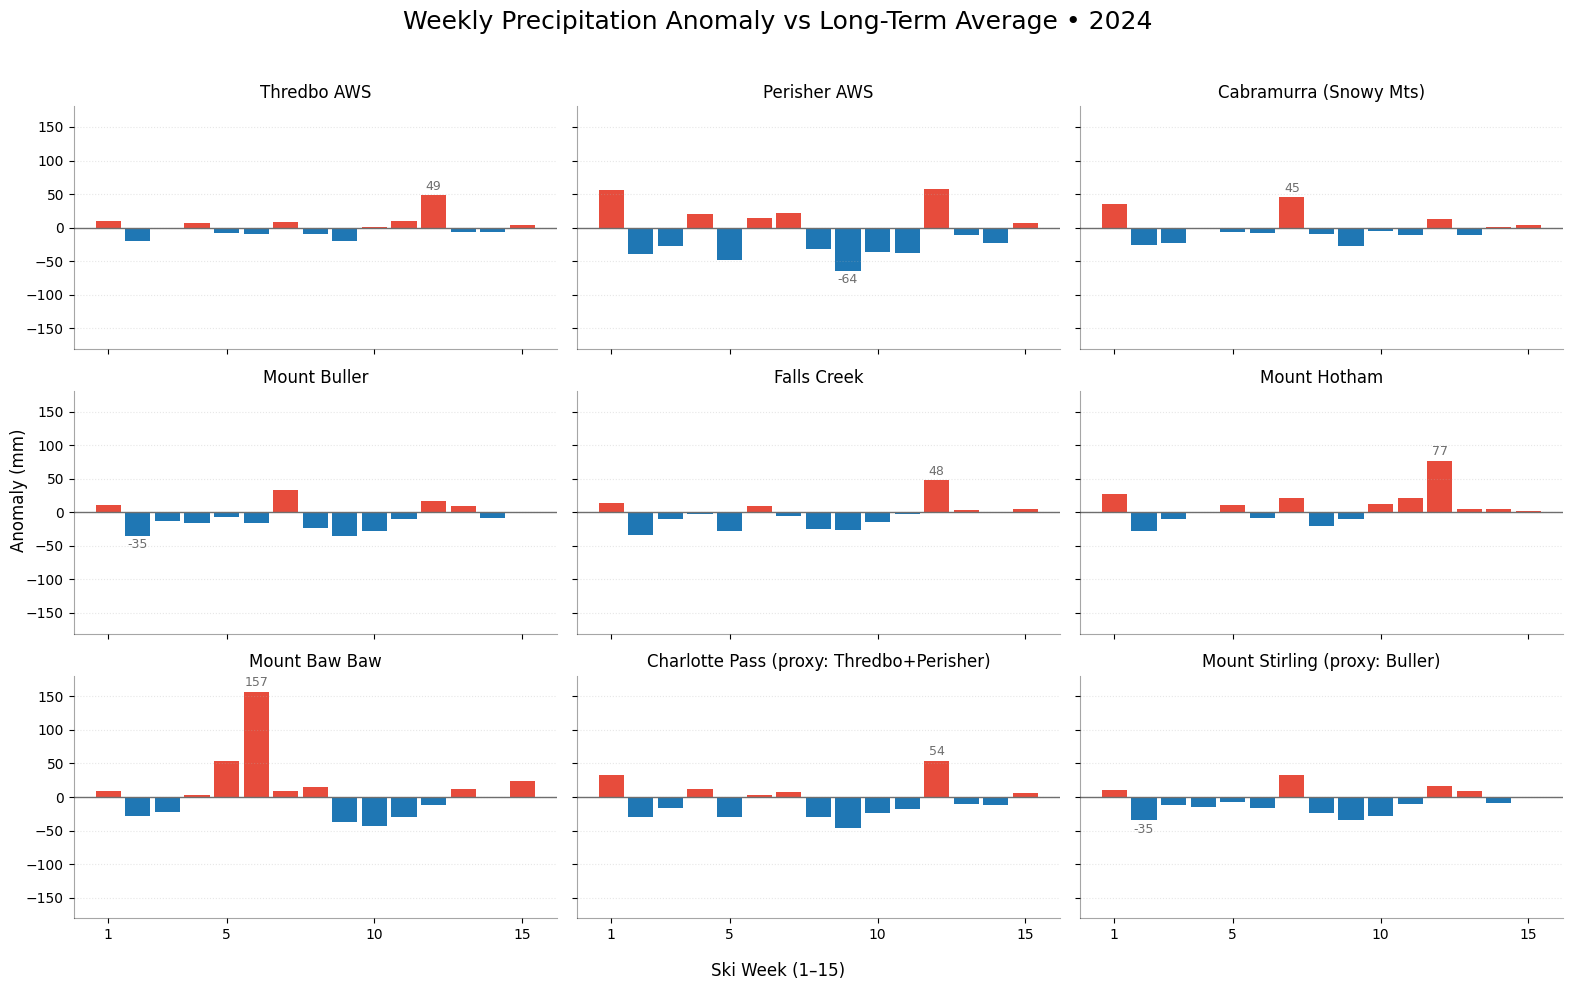

In [ ]:
def plot_all_resorts_grid(year, resorts):
    n = len(resorts)
    rows, cols = 3, 3
    fig, axes = plt.subplots(rows, cols, figsize=(16,10), sharex=True, sharey=True)
    axes = axes.flatten()

    # compute a common symmetric ylim across all resorts for fairness
    extrema = []
    weekly_cache = {}
    for r in resorts:
        wk_all = (climate[(climate["resort"]==r) & (climate["in_ski_season"])]
                  .groupby(["year","ski_week"])["rain_mm"].sum().reset_index())
        if wk_all.empty:
            weekly_cache[r] = None; continue
        clim = wk_all.groupby("ski_week")["rain_mm"].mean().rename("clim_mean")
        wk_y = (wk_all[wk_all["year"]==year]
                .set_index("ski_week")["rain_mm"]
                .reindex(range(1,16)).fillna(0).rename("rain_mm"))
        df = pd.concat([wk_y, clim], axis=1)
        if df["clim_mean"].isna().all():
            weekly_cache[r] = None; continue
        df["anomaly"] = (df["rain_mm"] - df["clim_mean"]).round(1)
        weekly_cache[r] = df
        extrema.append(np.nanmax(np.abs(df["anomaly"].values)))
    ymax = max(10, max(extrema) if extrema else 10)
    ylim = (-ymax*1.15, ymax*1.15)

    for ax, r in zip(axes, resorts):
        ax.set_ylim(*ylim)
        ax.axhline(0, color=GREY, lw=1)
        ax.grid(axis="y", linestyle=":", alpha=0.3)
        for s in ["top","right"]:
            ax.spines[s].set_visible(False)
        ax.spines["left"].set_alpha(0.35)
        ax.spines["bottom"].set_alpha(0.35)

        df = weekly_cache.get(r)
        if df is None:
            ax.text(0.5,0.5,"No data", ha="center", va="center", transform=ax.transAxes, color=GREY)
            ax.set_title(r, fontsize=12)
            continue

        weeks = df.index.values
        anom  = df["anomaly"].values
        colors = np.where(anom >= 0, RED, BLUE)
        ax.bar(weeks, anom, color=colors, edgecolor="none", width=0.85)
        ax.set_xticks([1,5,10,15])
        ax.set_title(r, fontsize=12)

        # label only the single most extreme bar
        if len(anom):
            k = int(np.nanargmax(np.abs(anom)))
            val = anom[k]
            va = "bottom" if val > 0 else "top"
            dy = 0.02*ymax if val > 0 else -0.02*ymax
            ax.text(weeks[k], val+dy, f"{val:.0f}", ha="center", va=va, fontsize=9, color=GREY)

    # shared labels
    fig.suptitle(f"Weekly Precipitation Anomaly vs Long-Term Average • {year}", fontsize=18, y=0.98)
    fig.supxlabel("Ski Week (1–15)", fontsize=12)
    fig.supylabel("Anomaly (mm)", fontsize=12)
    fig.tight_layout(rect=[0,0,1,0.96])
    plt.show()
plot_all_resorts_grid(YEAR, resorts9)
